<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Image-preliminaries" data-toc-modified-id="Image-preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image preliminaries</a></span></li><li><span><a href="#Recreate-inpute" data-toc-modified-id="Recreate-inpute-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recreate inpute</a></span></li></ul></div>

In [1]:
# Imports
from PIL import Image
from glob import glob
import numpy as np
import importlib
import vgg16_avg; importlib.reload(vgg16_avg)
from vgg16_avg import VGG16_Avg
from utils2 import limit_mem
import keras

Using TensorFlow backend.
/home/s/S.Rasp/.conda/envs/cbrain_gpu/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

## Image preliminaries

In [19]:
# So where are my images
# path = '/local/S.Rasp/fast.ai/train/'   # This contains all the category direcotires I assume
path = '/project/meteo/scratch/S.Rasp/fast.ai/train/'

In [20]:
# Grab a random image
image_fns = sorted(glob(path + '*/*'))
len(image_fns)

2054

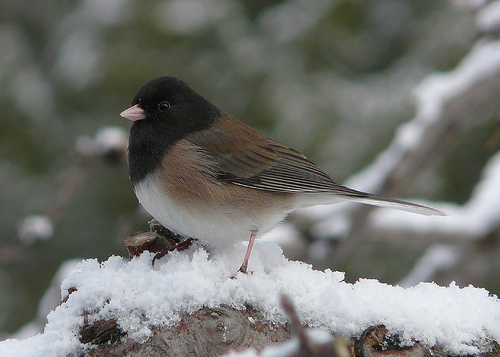

In [21]:
img = Image.open(image_fns[1]); img

In [22]:
imagenet_means = np.array([123.68, 116.779, 103.939], dtype=np.float32) # BGR

In [23]:
np.array(img).shape # --> channels last, but for now in RGB

(357, 500, 3)

In [24]:
# Write channel reverse function and subtract mean with lambda, huh
preproc = lambda x: (x - imagenet_means)[:, :, ::-1]

In [25]:
img_arr = preproc(np.array(img))

In [26]:
img_arr.shape

(357, 500, 3)

## Recreate inpute

In [3]:
# Load network, VGG16 with average pooling
vgg = VGG16_Avg(include_top=False)   # Do not include dense layers

/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:54: UserWarning: Update your `Conv2D` c

In [4]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [8]:
# Let's actually look at the activation of a certain layer for the image input
layer = vgg.get_layer('block4_conv1').output
layer   # This is a tensorflow tensor

<tf.Tensor 'block4_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

In [10]:
vgg.input   # this as well. Which means we can build a model / graph from this

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [11]:
inp2layer = keras.models.Model(vgg.input, layer)

In [12]:
inp2layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [32]:
[1] + list(img_arr.shape)

[1, 357, 500, 3]

In [35]:
pred = inp2layer.predict(img_arr.reshape(([1] + list(img_arr.shape))))

In [38]:
pred.shape # [same, x, y, channels]

(1, 44, 62, 512)